# A training example in Pytorch

Enchanced upon https://github.com/cmudeeplearning11785/Fall2018-tutorials/blob/master/recitation-2/pytorch_example.ipynb

## Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a cercle. More precisely, it will be the unit circle in the plan.
![](unitycircle.png)
## Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# Constants
#500000  ~5 minutes on GPU
#10000   ~5 seconds on GPU

n_samples = 10000
test_factor = 20
val_factor=20

In [3]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes   
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [15]:
def mk_dataset(n_samples=10000, test_factor=10, val_factor=10):
    # Generate the data
    trainx,trainy = sample_points(n_samples)
    valx,valy = sample_points(n_samples//test_factor)
    testx,testy = sample_points(n_samples//val_factor)
    #print(trainx.shape,trainy.shape)
    
    #To train our model, we will need to feed it with tensors. 
    #Let's transform our generated numpy arrays :
    trainx = torch.from_numpy(trainx).float()
    valx = torch.from_numpy(valx).float()
    testx = torch.from_numpy(testx).float()
    trainy = torch.from_numpy(trainy)
    valy = torch.from_numpy(valy)
    testy = torch.from_numpy(testy)
    #print(trainx.type(),trainy.type())
    
    return (trainx,trainy,valx,valy), testx, testy

## Model

Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (with one output, you would use BinaryCrossEntropy).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than what a hexagon could do.

In [5]:
def generate_single_hidden_MLP(n_hidden_neurons, active=nn.ReLU, active_args=()):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),
                         active(*active_args),
                         nn.Linear(n_hidden_neurons,2)
                        )
#unit test
generate_single_hidden_MLP(6, nn.Threshold, (0.5, 0))

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): Threshold(threshold=0.5, value=0)
  (2): Linear(in_features=6, out_features=2, bias=True)
)

## Activation functions

Let's compare effect of different activation function

### Step activation

It's not defined in the framework, but we define it

In [6]:
class step_activation(nn.Module):

    def __init__(self, threshold=0, value=1):
        super(step_activation, self).__init__()
        
    def forward(self, x):
        sign = torch.sign(x)
        return torch.clamp(sign, 0, 1)

#unit test
step_activation()(torch.Tensor([-1.0])).numpy(),
step_activation()(torch.Tensor([-0.0])).numpy(),
step_activation()(torch.Tensor([ 1.0])).numpy()

### Sigmoid, ReLU

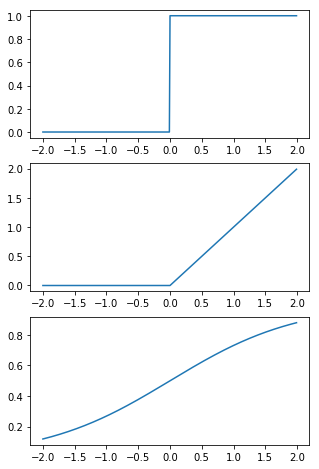

In [7]:
import numpy as np
t = np.arange(-2.0, 2.0, 0.01)
tt= torch.Tensor(t)

fig, axes = plt.subplots(3, figsize=(5,8))

activations = [step_activation, nn.ReLU, nn.Sigmoid]

for ax, active in zip(axes, activations):
    ax.plot(t, active()(tt).numpy())

plt.show()

## Training and diplaying routines
Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [8]:
def training_routine(net, dataset, n_iters, gpu, verbose=True):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    if verbose: print("Using GPU" if gpu else "Using CPU")
        
    # use the flag
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !

    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        # In verbose mode, print stats every so often,
        # in non-verbose mode - print only the final value
        n_info_iter = n_iters // 10
        
        if (i == n_iters - 1) or (verbose and i % n_info_iter == 0):
            print("At iteration", i)
            
            # compute the accuracy of the prediction
            train_accuracy = (train_labels.eq(train_output.argmax(dim=1))).float().mean()

            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)

            # compute the accuracy of the prediction
            val_accuracy = (val_labels.eq(val_output.argmax(dim=1))).float().mean()

            metrics = [train_loss, train_accuracy, val_loss, val_accuracy]
            info_vals= [float(v.cpu().detach().numpy()) for v in metrics]
            print("train loss {0:0.2f} train acc {1:0.2f} val loss {2:0.2f} val acc {3:0.2f}".format(*info_vals))

    net = net.cpu()
    return net

In [9]:
# helper to arrange plots on a grid in a nice way
import math
def get_grid(n):
    if n in [1,4,9]:
        w=int(math.sqrt(n))
        d=w
    elif n<4:        w,d=n,1
    elif n<7:        w,d=3,2
    else    :        w=4; d=n//w + (1 if n%w!=0 else 0)
    return d,w
get_grid(5)

(2, 3)

In [10]:
from itertools import chain

def print_models(models, datapoints, grid=None, fig_size_factor=5):
    if grid is None:
        grid = get_grid(len(models))

    fig, axes = plt.subplots( 
        *grid , squeeze=False,
        sharex='col', sharey='row', 
        figsize=(fig_size_factor*grid[1],fig_size_factor*grid[0])
    )
    
    for model, ax in zip(models, chain.from_iterable(axes)):
        out = model['model'](datapoints).argmax(dim=1).detach().numpy()
        green = datapoints.numpy()[np.where(out==1)]
        red = datapoints.numpy()[np.where(out==0)]

        ax.add_artist(plt.Circle((0, 0), 1, alpha=0.5, color='y'))
        ax.add_artist(plt.Circle((0, 0), 1, color='b',fill=False))

        ax.scatter(x=green[:,0],y=green[:,1], color='g',)
        ax.scatter(x=red[:,0],y=red[:,1], color='r',)

        ax.set_title(model['title'])
        ax.set_ylabel(str(model['neurons']) + " neurons")

In [11]:
import timeit 
def compute_models(activations, n_hidden_neurons, dataset,  
                   n_epochs=10000, gpu=True, verbose=False):
    models = []
    for active, active_args in activations:
        for n in n_hidden_neurons:
            model = generate_single_hidden_MLP(n, active, active_args)
            title = active.__name__+str(active_args)
            print("Computing {} for {} neurons ...".format(title, n), end='')
            start = timeit.default_timer()
            training_routine(model,dataset,n_epochs,gpu, verbose=verbose)
            stop = timeit.default_timer()
            print("\b\b\b in {:.2f} sec".format(stop-start))
            models.append(
                {"model" : model,
                 "title" : title,
                 "neurons": n}
            )
    return models

## Use of GPU flag

In [12]:
torch.cuda.is_available() # to know if you actually can use the GPU

True

In [13]:
gpu = True #default, but flips if cuda is not available
gpu = gpu or torch.cuda.is_available() 
gpu

True

## Models with Step Activation

In [16]:
n_samples = 10000
dataset, testx, _ = mk_dataset(n_samples)

Computing step_activation() for 1 neurons ...At iteration 9999
train loss 0.69 train acc 0.55 val loss 0.69 val acc 0.55
 in 4.90 sec
Computing step_activation() for 2 neurons ...At iteration 9999
train loss 0.68 train acc 0.57 val loss 0.68 val acc 0.57
 in 4.19 sec
Computing step_activation() for 3 neurons ...At iteration 9999
train loss 0.60 train acc 0.64 val loss 0.63 val acc 0.62
 in 4.22 sec
Computing step_activation() for 4 neurons ...At iteration 9999
train loss 0.53 train acc 0.75 val loss 0.57 val acc 0.71
 in 4.23 sec
Computing step_activation() for 6 neurons ...At iteration 9999
train loss 0.51 train acc 0.71 val loss 0.53 val acc 0.68
 in 4.24 sec
Computing step_activation() for 8 neurons ...At iteration 9999
train loss 0.30 train acc 0.87 val loss 0.29 val acc 0.87
 in 4.26 sec


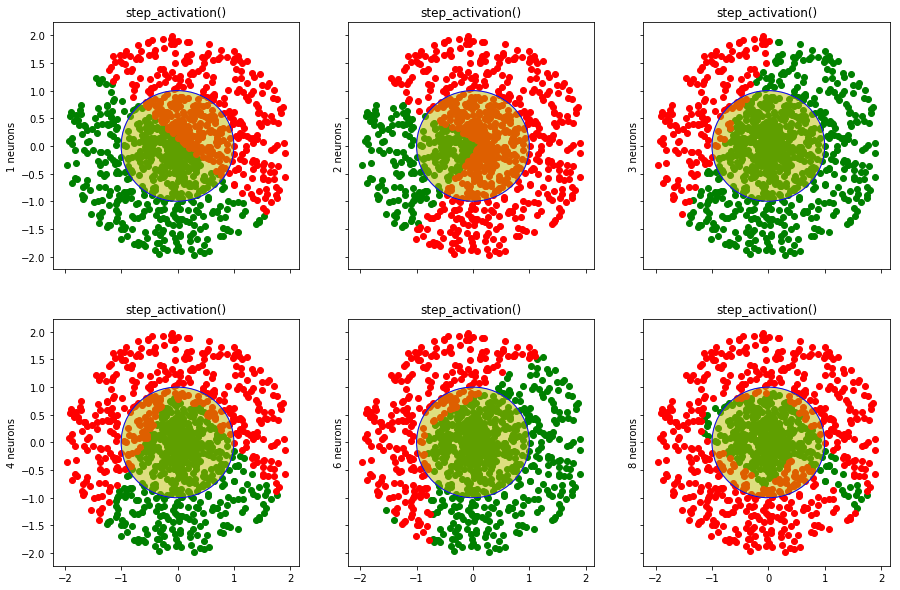

In [17]:
activations = [(step_activation,())]
n_hidden_neurons = [1,2,3,4,6,8]

models=compute_models(activations, n_hidden_neurons, dataset)

print_models(models, testx)

## Activations vs. number of neurons

Computing step_activation() for 2 neurons ...At iteration 9999
train loss 0.67 train acc 0.60 val loss 0.68 val acc 0.59
 in 4.20 sec
Computing step_activation() for 3 neurons ...At iteration 9999
train loss 0.47 train acc 0.73 val loss 0.48 val acc 0.71
 in 4.23 sec
Computing step_activation() for 6 neurons ...At iteration 9999
train loss 0.31 train acc 0.89 val loss 0.31 val acc 0.89
 in 4.82 sec
Computing Sigmoid() for 2 neurons ...At iteration 9999
train loss 0.69 train acc 0.40 val loss 0.69 val acc 0.40
 in 5.29 sec
Computing Sigmoid() for 3 neurons ...At iteration 9999
train loss 0.69 train acc 0.47 val loss 0.69 val acc 0.45
 in 5.72 sec
Computing Sigmoid() for 6 neurons ...At iteration 9999
train loss 0.69 train acc 0.60 val loss 0.69 val acc 0.60
 in 4.16 sec
Computing ReLU() for 2 neurons ...At iteration 9999
train loss 0.45 train acc 0.78 val loss 0.45 val acc 0.77
 in 4.60 sec
Computing ReLU() for 3 neurons ...At iteration 9999
train loss 0.60 train acc 0.64 val los

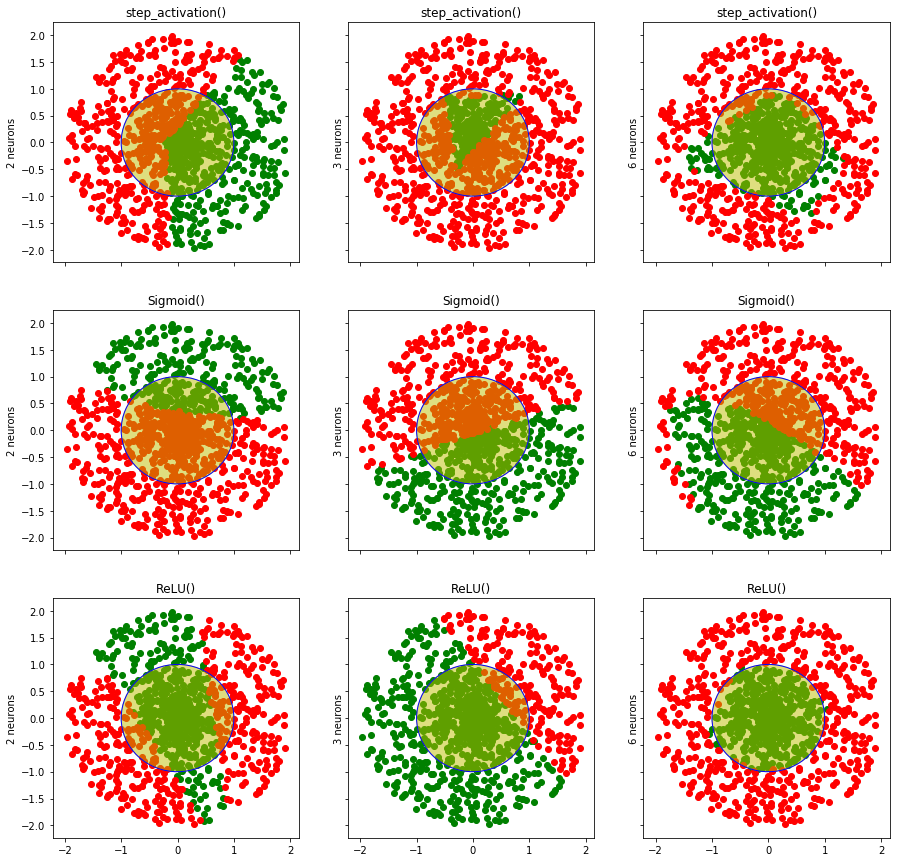

In [18]:
activations = [(step_activation,()),(nn.Sigmoid,()), (nn.ReLU,())]
n_hidden_neurons = [2,3,6]

models = compute_models(activations, n_hidden_neurons, dataset)
print_models(models, testx)

## More epochs

Computing step_activation() for 1 neurons ...At iteration 99999
train loss 0.65 train acc 0.56 val loss 0.65 val acc 0.57
 in 61.73 sec
Computing step_activation() for 2 neurons ...At iteration 99999
train loss 0.66 train acc 0.62 val loss 0.67 val acc 0.61
 in 46.46 sec
Computing step_activation() for 3 neurons ...At iteration 99999
train loss 0.56 train acc 0.73 val loss 0.55 val acc 0.73
 in 46.84 sec
Computing step_activation() for 4 neurons ...At iteration 99999
train loss 0.49 train acc 0.75 val loss 0.49 val acc 0.76
 in 53.95 sec
Computing step_activation() for 6 neurons ...At iteration 99999
train loss 0.59 train acc 0.70 val loss 0.60 val acc 0.71
 in 53.74 sec
Computing step_activation() for 8 neurons ...At iteration 99999
train loss 0.41 train acc 0.80 val loss 0.41 val acc 0.80
 in 52.44 sec


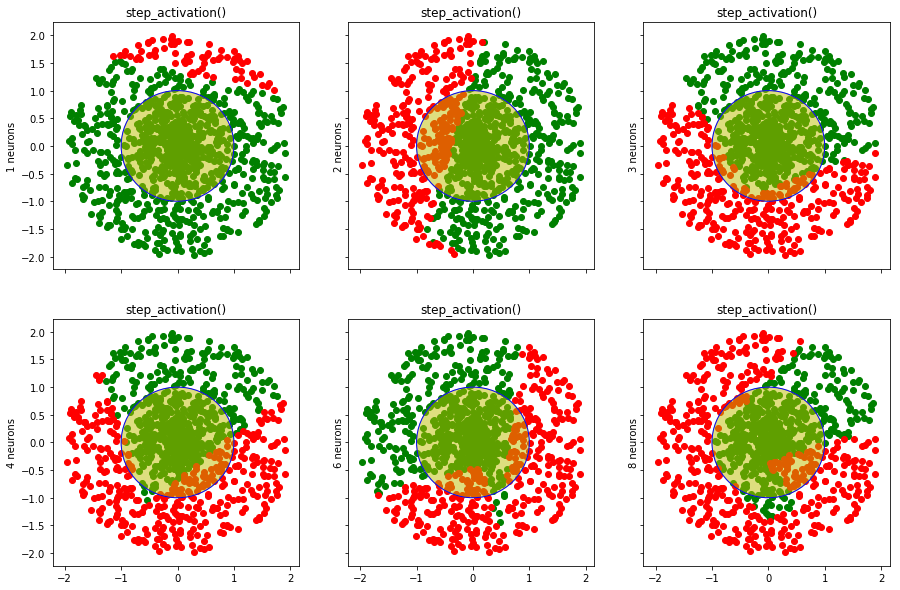

In [19]:
activations = [(step_activation,())]
n_hidden_neurons = [1,2,3,4,6,8]
n_epochs = 100000

models=compute_models(activations, n_hidden_neurons, 
                      dataset, n_epochs=n_epochs)
print_models(models, testx)

## 100k Samples

In [20]:
n_samples = 100000
dataset, testx, _ = mk_dataset(n_samples)

Computing step_activation() for 2 neurons ...At iteration 9999
train loss 0.54 train acc 0.77 val loss 0.54 val acc 0.77
 in 35.29 sec
Computing step_activation() for 3 neurons ...At iteration 9999
train loss 0.62 train acc 0.61 val loss 0.62 val acc 0.61
 in 35.37 sec
Computing step_activation() for 6 neurons ...At iteration 9999
train loss 0.28 train acc 0.90 val loss 0.29 val acc 0.90
 in 36.27 sec
Computing Sigmoid() for 2 neurons ...At iteration 9999
train loss 0.69 train acc 0.57 val loss 0.69 val acc 0.57
 in 34.99 sec
Computing Sigmoid() for 3 neurons ...At iteration 9999
train loss 0.68 train acc 0.62 val loss 0.68 val acc 0.61
 in 35.08 sec
Computing Sigmoid() for 6 neurons ...At iteration 9999
train loss 0.61 train acc 0.78 val loss 0.61 val acc 0.77
 in 35.68 sec
Computing ReLU() for 2 neurons ...At iteration 9999
train loss 0.45 train acc 0.78 val loss 0.45 val acc 0.78
 in 35.04 sec
Computing ReLU() for 3 neurons ...At iteration 9999
train loss 0.17 train acc 0.95 

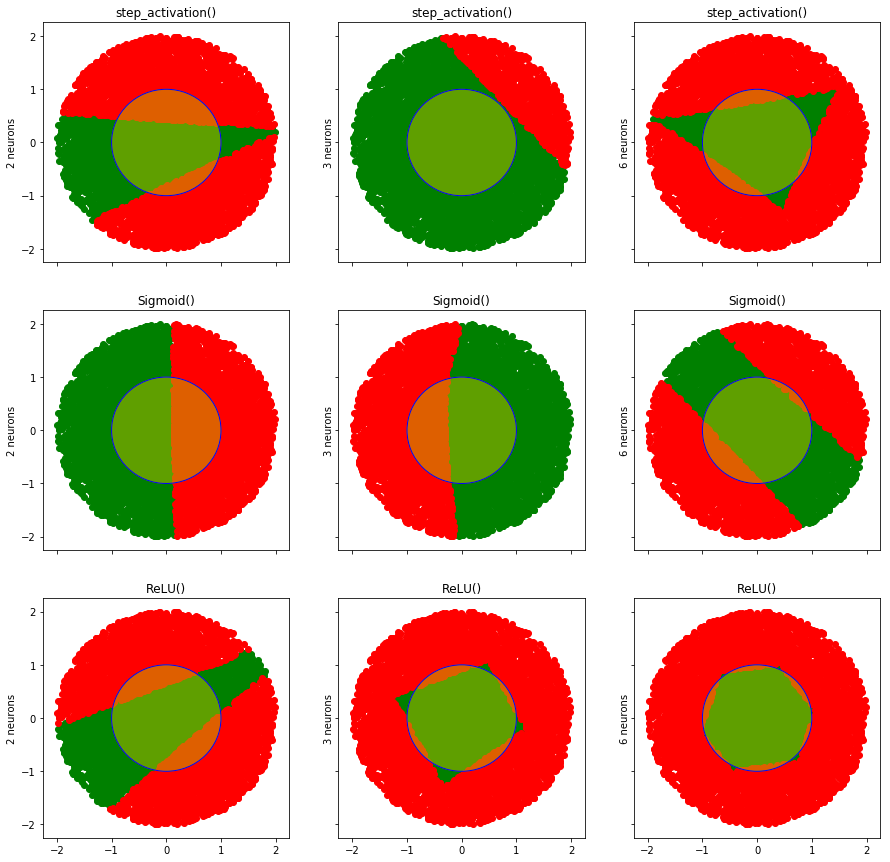

In [21]:
activations = [(step_activation,()),(nn.Sigmoid,()), (nn.ReLU,())]
n_hidden_neurons = [2,3,6]

models = compute_models(activations, n_hidden_neurons, dataset)
print_models(models, testx)

### More tests? include number of epochs? Loss plots?